In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [2]:

def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(
        "/home/saltfish/Programming/Python/data_mining/ch11/FiraCode-Medium.otf", 22
    )
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image


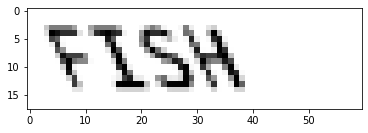

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

image = create_captcha("FISH", shear=0.5, scale=0.6)
plt.imshow(image, cmap="Greys")

In [4]:
from skimage.measure import label, regionprops


def segment_image(image):
    # 标记找到连通的非黑色像素的子图像
    labeled_image = label(image > 0.2, connectivity=1, background=0)
    subimages = []
    # 拆分子图
    for region in regionprops(labeled_image):
        # 提取子图
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        # 未找到子图，返回这个图片本身
        return [
            image,
        ]
    return subimages


In [5]:
subimages = segment_image(image)

In [6]:
len(subimages)

4

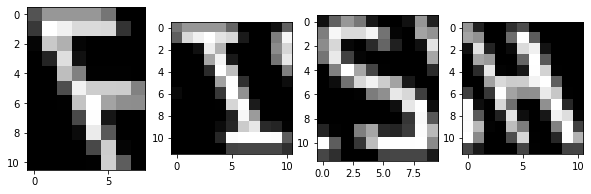

In [7]:
# 选出四张小图片
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [8]:
from sklearn.utils import check_random_state

random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [9]:

def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return (
        create_captcha(letter, shear=shear, size=(30, 30), scale=scale),
        letters.index(letter),
    )


The target for this image is: L


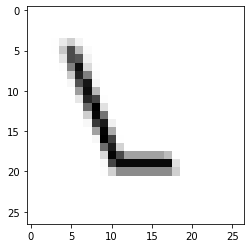

In [10]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print("The target for this image is: {0}".format(letters[target]))

In [11]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array(
    [tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset]
)
dataset = np.array(dataset, dtype="float")
targets = np.array(targets)

In [12]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0], 1))

In [13]:
y = y.todense()
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [14]:
from keras.layers import Dense
from keras.models import Sequential

hidden_layer = Dense(100, input_dim=X_train.shape[1])
output_layer = Dense(y_train.shape[1])

model = Sequential(layers=[hidden_layer, output_layer])
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

Using TensorFlow backend.


In [15]:
model.fit(X_train, y_train, epochs=1000, verbose=False)

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
f1_score(y_pred=y_pred.argmax(axis=1), y_true=y_test.argmax(axis=1), average="macro")

1.0

In [17]:
print(classification_report(y_pred=y_pred.argmax(axis=1), y_true=y_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         1
          17       1.00    